In [97]:
# Cell 1: Setup and Imports
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)
from xgboost import XGBClassifier
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Create directories
import os
os.makedirs('../models', exist_ok=True)
os.makedirs('../results/figures', exist_ok=True)
os.makedirs('../results/metrics', exist_ok=True)
os.makedirs('../results/interpretations', exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("colorblind")
%matplotlib inline

In [98]:
# Cell 2: Data Loading and Exploration
# ==========================
# Load the dataset
data_path = '../data/german_credit_data.csv'
df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

# Basic information about the dataset
print("\nDataset Info:")
df.info()

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check target distribution
print("\nTarget variable distribution:")
print(df['class'].value_counts())
print("\nTarget variable proportions:")
print(df['class'].value_counts(normalize=True))

Dataset shape: (1000, 21)

First few rows:

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14 

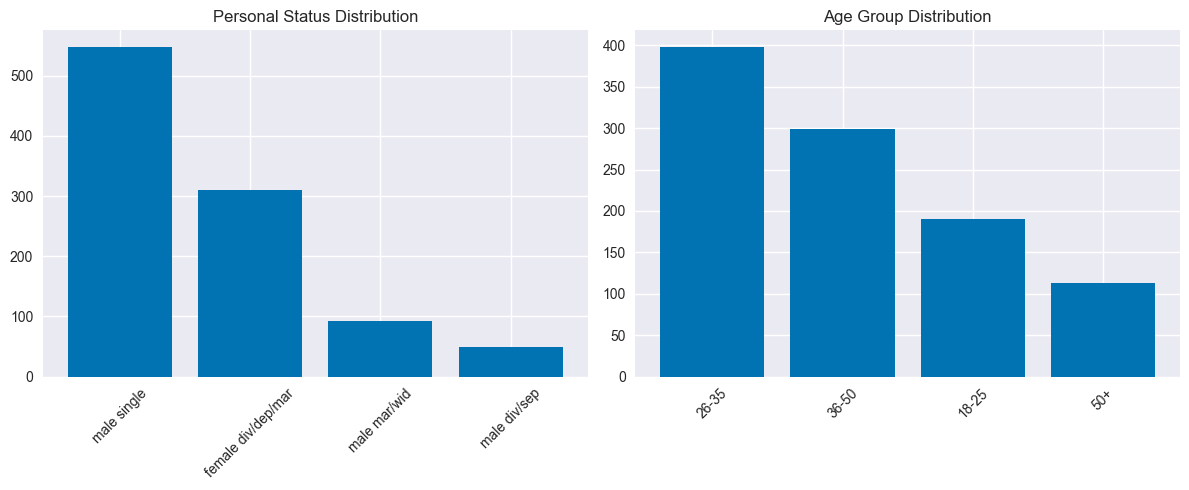

In [99]:
# Cell 3: Sensitive Attributes Analysis
# ==========================
# Define sensitive attributes
sensitive_attributes = ['personal_status', 'age']
df['age_group'] = pd.cut(df['age'], bins=[18, 25, 35, 50, 100], 
                         labels=['18-25', '26-35', '36-50', '50+'])

# Check distribution of sensitive attributes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Personal status distribution
personal_status_counts = df['personal_status'].value_counts()
axes[0].bar(personal_status_counts.index, personal_status_counts.values)
axes[0].set_title('Personal Status Distribution')
axes[0].tick_params(axis='x', rotation=45)

# Age group distribution
age_group_counts = df['age_group'].value_counts()
axes[1].bar(age_group_counts.index, age_group_counts.values)
axes[1].set_title('Age Group Distribution')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/figures/sensitive_attributes_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Create interpretation file
with open('../results/interpretations/sensitive_attributes_distribution.txt', 'w') as f:
    f.write("SENSITIVE ATTRIBUTES DISTRIBUTION ANALYSIS\n")
    f.write("=" * 50 + "\n\n")
    f.write("Personal Status Distribution:\n")
    for status, count in personal_status_counts.items():
        perc = (count / len(df)) * 100
        f.write(f"- {status}: {count} respondents ({perc:.2f}%)\n")
    
    f.write("\nAge Group Distribution:\n")
    for group, count in age_group_counts.items():
        perc = (count / len(df)) * 100
        f.write(f"- {group}: {count} respondents ({perc:.2f}%)\n")
    
    f.write(f"\nSummary:\n")
    f.write(f"- The most common personal status is {personal_status_counts.idxmax()}.\n")
    f.write(f"- The largest age group represented is {age_group_counts.idxmax()}.\n")

In [100]:
# Cell 4: Data Preprocessing
# ==========================
# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Encode the target variable (bad=0, good=1)
le = LabelEncoder()
df_processed['class'] = le.fit_transform(df_processed['class'])

# Save the label encoder for future use
joblib.dump(le, '../models/label_encoder.pkl')

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()

# Remove target variable and 'age' from numerical columns
numerical_cols.remove('class')
numerical_cols.remove('age')  # We'll use age_group instead

# Create age_group for categorical processing
df_processed['age_group'] = pd.cut(df['age'], bins=[18, 25, 35, 50, 100],
                                   labels=['18-25', '26-35', '36-50', '50+'])
categorical_cols.append('age_group')

# One-hot encode categorical variables
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

print("Processed dataset shape:", df_processed.shape)
df_processed.head()

Processed dataset shape: (1000, 52)


,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,class,checking_status_<0,checking_status_>=200,...,housing_own,housing_rent,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_yes,foreign_worker_yes,age_group_26-35,age_group_36-50,age_group_50+
0,6,1169,4,4,67,2,1,1,True,False,...,True,False,True,False,False,True,True,False,False,True
1,48,5951,2,2,22,1,1,0,False,False,...,True,False,True,False,False,False,True,False,False,False
2,12,2096,2,3,49,1,2,1,False,False,...,True,False,False,False,True,False,True,False,True,False
3,42,7882,2,4,45,1,2,1,True,False,...,False,False,True,False,False,False,True,False,True,False
4,24,4870,3,4,53,2,2,0,True,False,...,False,False,True,False,False,False,True,False,False,True


In [101]:
# Cell 5: Train-Test Split and Feature Scaling
# ==========================
# Split features and target
X = df_processed.drop('class', axis=1)
y = df_processed['class']

# Save feature names for later use
feature_names = X.columns.tolist()
joblib.dump(feature_names, '../models/feature_names.pkl')

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target distribution:", np.bincount(y_train))
print("Test target distribution:", np.bincount(y_test))

# Standardize numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Save the scaler
joblib.dump(scaler, '../models/scaler.pkl')

X_train.head()

Training set shape: (800, 51)
Test set shape: (200, 51)
Training target distribution: [240 560]
Test target distribution: [ 60 140]


,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_<0,checking_status_>=200,checking_status_no checking,...,housing_own,housing_rent,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_yes,foreign_worker_yes,age_group_26-35,age_group_36-50,age_group_50+
675,0.755149,0.485384,0.905268,1.044365,26,-0.719852,-0.442509,False,False,True,...,False,True,False,False,False,True,True,True,False,False
703,0.755149,-0.246578,0.905268,-0.758207,41,1.035885,-0.442509,False,False,False,...,True,False,True,False,False,False,True,False,True,False
12,-0.726746,-0.584573,-1.797024,-1.659492,22,-0.719852,-0.442509,False,False,False,...,True,False,True,False,False,True,True,False,False,False
845,0.014201,0.285331,-0.896260,0.143079,35,-0.719852,-0.442509,False,False,False,...,True,False,True,False,False,True,True,True,False,False
795,-0.973728,-0.319522,-0.896260,1.044365,22,-0.719852,-0.442509,False,False,True,...,False,True,True,False,False,False,True,False,False,False


In [102]:
# Cell 6: Define Metrics and Utility Functions
# ==========================
def fairness_metrics(y_true, y_pred, sensitive_features, privileged_groups):
    """
    Calculate various fairness metrics
    """
    metrics = {}
    
    for feature, values in sensitive_features.items():
        privileged_value = privileged_groups[feature]
        
        # Create masks for privileged and unprivileged groups
        privileged_mask = (values == privileged_value)
        unprivileged_mask = (values != privileged_value)
        
        # Statistical Parity Difference (SPD)
        p_privileged = y_pred[privileged_mask].mean() if sum(privileged_mask) > 0 else 0
        p_unprivileged = y_pred[unprivileged_mask].mean() if sum(unprivileged_mask) > 0 else 0
        spd = p_unprivileged - p_privileged
        metrics[f'{feature}_SPD'] = spd
        
        # Disparate Impact (DI)
        di = p_unprivileged / p_privileged if p_privileged != 0 else float('inf')
        metrics[f'{feature}_DI'] = di
        
        # Equal Opportunity Difference (EOD)
        # True positive rates for both groups
        tp_privileged = np.sum((y_true[privileged_mask] == 1) & (y_pred[privileged_mask] == 1))
        fn_privileged = np.sum((y_true[privileged_mask] == 1) & (y_pred[privileged_mask] == 0))
        tpr_privileged = tp_privileged / (tp_privileged + fn_privileged) if (tp_privileged + fn_privileged) > 0 else 0
        
        tp_unprivileged = np.sum((y_true[unprivileged_mask] == 1) & (y_pred[unprivileged_mask] == 1))
        fn_unprivileged = np.sum((y_true[unprivileged_mask] == 1) & (y_pred[unprivileged_mask] == 0))
        tpr_unprivileged = tp_unprivileged / (tp_unprivileged + fn_unprivileged) if (tp_unprivileged + fn_unprivileged) > 0 else 0
        
        eod = tpr_unprivileged - tpr_privileged
        metrics[f'{feature}_EOD'] = eod
        
        # Average Odds Difference (AOD)
        # False positive rates for both groups
        fp_privileged = np.sum((y_true[privileged_mask] == 0) & (y_pred[privileged_mask] == 1))
        tn_privileged = np.sum((y_true[privileged_mask] == 0) & (y_pred[privileged_mask] == 0))
        fpr_privileged = fp_privileged / (fp_privileged + tn_privileged) if (fp_privileged + tn_privileged) > 0 else 0
        
        fp_unprivileged = np.sum((y_true[unprivileged_mask] == 0) & (y_pred[unprivileged_mask] == 1))
        tn_unprivileged = np.sum((y_true[unprivileged_mask] == 0) & (y_pred[unprivileged_mask] == 0))
        fpr_unprivileged = fp_unprivileged / (fp_unprivileged + tn_unprivileged) if (fp_unprivileged + tn_unprivileged) > 0 else 0
        
        aod = 0.5 * ((fpr_unprivileged - fpr_privileged) + (tpr_unprivileged - tpr_privileged))
        metrics[f'{feature}_AOD'] = aod
    
    return metrics

def performance_metrics(y_true, y_pred, y_proba=None):
    """
    Calculate performance metrics
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
    }
    
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    
    return metrics

def save_interpretation(filename, title, description, values=None):
    """
    Save interpretation file for plots
    """
    with open(f'../results/interpretations/{filename}', 'w') as f:
        f.write(f"{title}\n")
        f.write("=" * len(title) + "\n\n")
        f.write(description + "\n\n")
        
        if values is not None:
            f.write("Key values:\n")
            for key, value in values.items():
                f.write(f"- {key}: {value}\n")

In [103]:
# Cell 7: Prepare Sensitive Features for Evaluation
# ==========================
# Extract sensitive features for test set
test_indices = X_test.index
sensitive_features_test = {
    'personal_status': df.loc[test_indices, 'personal_status'].values,
    'age_group': df.loc[test_indices, 'age_group'].values
}

# Define privileged groups
privileged_groups = {
    'personal_status': 'male single',  # Assuming this is the privileged group
    'age_group': '26-35'  # Assuming this is the privileged group
}

In [105]:
# Cell 8: Baseline Models
# ==========================
# Clean feature names to remove special characters that XGBoost doesn't like
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

# Clean column names (remove special characters that XGBoost doesn't like)
X_train_clean.columns = X_train_clean.columns.str.replace(r'[\[\]<>]', '_', regex=True)
X_test_clean.columns = X_test_clean.columns.str.replace(r'[\[\]<>]', '_', regex=True)

# Check for any remaining problematic characters
problematic_chars = ['[', ']', '<', '>']
for col in X_train_clean.columns:
    for char in problematic_chars:
        if char in col:
            print(f"WARNING: Column '{col}' still contains problematic character '{char}'")

# Save cleaned feature names for later use
feature_names_clean = X_train_clean.columns.tolist()
joblib.dump(feature_names_clean, '../models/feature_names_clean.pkl')

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Train and evaluate baseline models
baseline_results = {}

for name, model in models.items():
    print(f"Training {name} baseline...")
    
    # For XGBoost, convert to numpy arrays to avoid column name issues
    if name == 'XGBoost':
        X_train_final = X_train_clean.values
        X_test_final = X_test_clean.values
        print(f"XGBoost training data shape: {X_train_final.shape}")
        print("Using numpy arrays for XGBoost to avoid feature name issues")
    else:
        X_train_final = X_train_clean
        X_test_final = X_test_clean
        print(f"{name} training data shape: {X_train_final.shape}")
    
    # Train model
    try:
        model.fit(X_train_final, y_train)
        print(f"Successfully trained {name}")
    except Exception as e:
        print(f"Error training {name}: {e}")
        # Skip this model if it fails
        continue
    
    # Save model
    joblib.dump(model, f'../models/{name.replace(" ", "_").lower()}_baseline.pkl')
    
    # Make predictions
    try:
        if name == 'XGBoost':
            y_pred = model.predict(X_test_final)
            y_proba = model.predict_proba(X_test_final)[:, 1] if hasattr(model, "predict_proba") else None
        else:
            y_pred = model.predict(X_test_final)
            y_proba = model.predict_proba(X_test_final)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Calculate metrics
        perf_metrics = performance_metrics(y_test, y_pred, y_proba)
        fair_metrics = fairness_metrics(y_test, y_pred, sensitive_features_test, privileged_groups)
        
        # Combine metrics
        baseline_results[name] = {**perf_metrics, **fair_metrics}
        
        print(f"Completed {name}")
    except Exception as e:
        print(f"Error making predictions with {name}: {e}")

# Convert results to DataFrame
if baseline_results:
    baseline_results_df = pd.DataFrame(baseline_results).T
    baseline_results_df.to_csv('../results/metrics/baseline_models_metrics.csv')
    
    print("\nBaseline models training completed successfully!")
    print(f"Models trained: {list(baseline_results.keys())}")
    baseline_results_df
else:
    print("No models were successfully trained. Please check the error messages above.")

Training Logistic Regression baseline...
Logistic Regression training data shape: (800, 51)
Successfully trained Logistic Regression
Completed Logistic Regression
Training Random Forest baseline...
Random Forest training data shape: (800, 51)
Successfully trained Random Forest
Completed Random Forest
Training XGBoost baseline...
XGBoost training data shape: (800, 51)
Using numpy arrays for XGBoost to avoid feature name issues
Successfully trained XGBoost
Completed XGBoost

Baseline models training completed successfully!
Models trained: ['Logistic Regression', 'Random Forest', 'XGBoost']


In [106]:
# Cell 9: Fairness Pipeline Class
# ==========================
class FairnessPipeline:
    def __init__(self, model, model_name):
        self.model = model
        self.model_name = model_name
        self.sample_weights = None
        self.group_thresholds = None
    
    def apply_reweighting(self, X, y, sensitive_features):
        """Pre-processing: Apply reweighting to address bias"""
        # Calculate weights based on class imbalance
        class_weights = len(y) / (2 * np.bincount(y))
        self.sample_weights = np.array([class_weights[0] if label == 0 else class_weights[1] for label in y])
        
        # Additional reweighting based on sensitive attributes
        personal_status_values = sensitive_features['personal_status']
        personal_status_counts = pd.Series(personal_status_values).value_counts()
        
        # Calculate weights to balance representation across groups
        status_weights = {}
        for status in personal_status_counts.index:
            status_weights[status] = len(y) / (len(personal_status_counts) * personal_status_counts[status])
        
        # Combine class weights and sensitive attribute weights
        for i, status in enumerate(personal_status_values):
            self.sample_weights[i] *= status_weights[status]
        
        return self
    
    def fit_with_fairness(self, X, y, sensitive_features):
        """In-processing: Train model with fairness constraints"""
        # Apply reweighting
        self.apply_reweighting(X, y, sensitive_features)
        
        # Train model with sample weights
        if self.model_name == 'XGBoost':
            # XGBoost has different parameter for class imbalance
            scale_pos_weight = sum(y == 0) / sum(y == 1)
            self.model.set_params(scale_pos_weight=scale_pos_weight)
            self.model.fit(X, y)
        else:
            self.model.fit(X, y, sample_weight=self.sample_weights)
        
        return self
    
    def apply_threshold_adjustment(self, X, y, sensitive_features):
        """Post-processing: Apply group-specific threshold adjustment"""
        # Get predicted probabilities
        y_proba = self.model.predict_proba(X)[:, 1]
        
        # Calculate optimal thresholds for each group
        personal_status_groups = np.unique(sensitive_features['personal_status'])
        self.group_thresholds = {}
        
        for group in personal_status_groups:
            group_mask = (sensitive_features['personal_status'] == group)
            y_true_group = y[group_mask]
            y_proba_group = y_proba[group_mask]
            
            # Find threshold that maximizes F1 score for this group
            best_threshold = 0.5
            best_f1 = 0
            
            for threshold in np.linspace(0.1, 0.9, 50):
                y_pred_group = (y_proba_group >= threshold).astype(int)
                f1 = f1_score(y_true_group, y_pred_group, zero_division=0)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
            
            self.group_thresholds[group] = best_threshold
        
        return self
    
    def predict_fair(self, X, sensitive_features):
        """Make predictions using the fairness pipeline"""
        # Get base predictions
        y_proba = self.model.predict_proba(X)[:, 1]
        
        # Apply group-specific thresholds if available
        if self.group_thresholds is not None:
            personal_status_values = sensitive_features['personal_status']
            y_pred = np.zeros_like(y_proba)
            
            for group, threshold in self.group_thresholds.items():
                group_mask = (personal_status_values == group)
                y_pred[group_mask] = (y_proba[group_mask] >= threshold).astype(int)
            
            return y_pred
        else:
            # Fall back to standard prediction
            return self.model.predict(X)
    
    def save_pipeline(self):
        """Save the complete fairness pipeline"""
        pipeline_data = {
            'model': self.model,
            'model_name': self.model_name,
            'sample_weights': self.sample_weights,
            'group_thresholds': self.group_thresholds
        }
        joblib.dump(pipeline_data, f'../models/{self.model_name.replace(" ", "_").lower()}_fairness_pipeline.pkl')

In [108]:
# Cell 10: Apply Complete Fairness Pipeline (Updated)
# ==========================
# Prepare sensitive features for training set
train_indices = X_train.index
sensitive_features_train = {
    'personal_status': df.loc[train_indices, 'personal_status'].values,
    'age_group': df.loc[train_indices, 'age_group'].values
}

# Apply fairness pipeline to each model
fairness_results = {}

for name, model in models.items():
    print(f"Applying fairness pipeline to {name}...")
    
    # For XGBoost, use the cleaned data and convert to numpy arrays
    if name == 'XGBoost':
        X_train_final = X_train_clean.values
        X_test_final = X_test_clean.values
        print("Using numpy arrays for XGBoost to avoid feature name issues")
    else:
        X_train_final = X_train_clean
        X_test_final = X_test_clean
    
    # Create and apply fairness pipeline
    pipeline = FairnessPipeline(model, name)
    pipeline.fit_with_fairness(X_train_final, y_train, sensitive_features_train)
    pipeline.apply_threshold_adjustment(X_train_final, y_train, sensitive_features_train)
    
    # Save the complete pipeline
    pipeline.save_pipeline()
    
    # Make fair predictions
    if name == 'XGBoost':
        y_pred_fair = pipeline.predict_fair(X_test_final, sensitive_features_test)
        y_proba_fair = model.predict_proba(X_test_final)[:, 1] if hasattr(model, "predict_proba") else None
    else:
        y_pred_fair = pipeline.predict_fair(X_test_final, sensitive_features_test)
        y_proba_fair = model.predict_proba(X_test_final)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    perf_metrics = performance_metrics(y_test, y_pred_fair, y_proba_fair)
    fair_metrics = fairness_metrics(y_test, y_pred_fair, sensitive_features_test, privileged_groups)
    
    # Combine metrics
    fairness_results[name] = {**perf_metrics, **fair_metrics}
    
    print(f"Completed fairness pipeline for {name}")

# Convert results to DataFrame
fairness_results_df = pd.DataFrame(fairness_results).T
fairness_results_df.to_csv('../results/metrics/fairness_pipeline_metrics.csv')

print("\nFairness pipeline completed successfully!")
fairness_results_df

Applying fairness pipeline to Logistic Regression...
Completed fairness pipeline for Logistic Regression
Applying fairness pipeline to Random Forest...
Completed fairness pipeline for Random Forest
Applying fairness pipeline to XGBoost...
Using numpy arrays for XGBoost to avoid feature name issues
Completed fairness pipeline for XGBoost

Fairness pipeline completed successfully!


,accuracy,precision,recall,f1,roc_auc,personal_status_SPD,personal_status_DI,personal_status_EOD,personal_status_AOD,age_group_SPD,age_group_DI,age_group_EOD,age_group_AOD
Logistic Regression,0.700,0.766667,0.821429,0.793103,0.742262,-0.142045,0.825175,-0.119048,-0.115327,0.021222,1.028802,0.018923,0.068986
Random Forest,0.735,0.737705,0.964286,0.835913,0.764107,0.030032,1.033303,0.029762,0.061756,-0.030985,0.966833,-0.002103,-0.024861
XGBoost,0.730,0.752941,0.914286,0.825806,0.742024,0.024351,1.029014,-0.005952,0.084077,-0.008489,0.990074,0.000841,0.024230


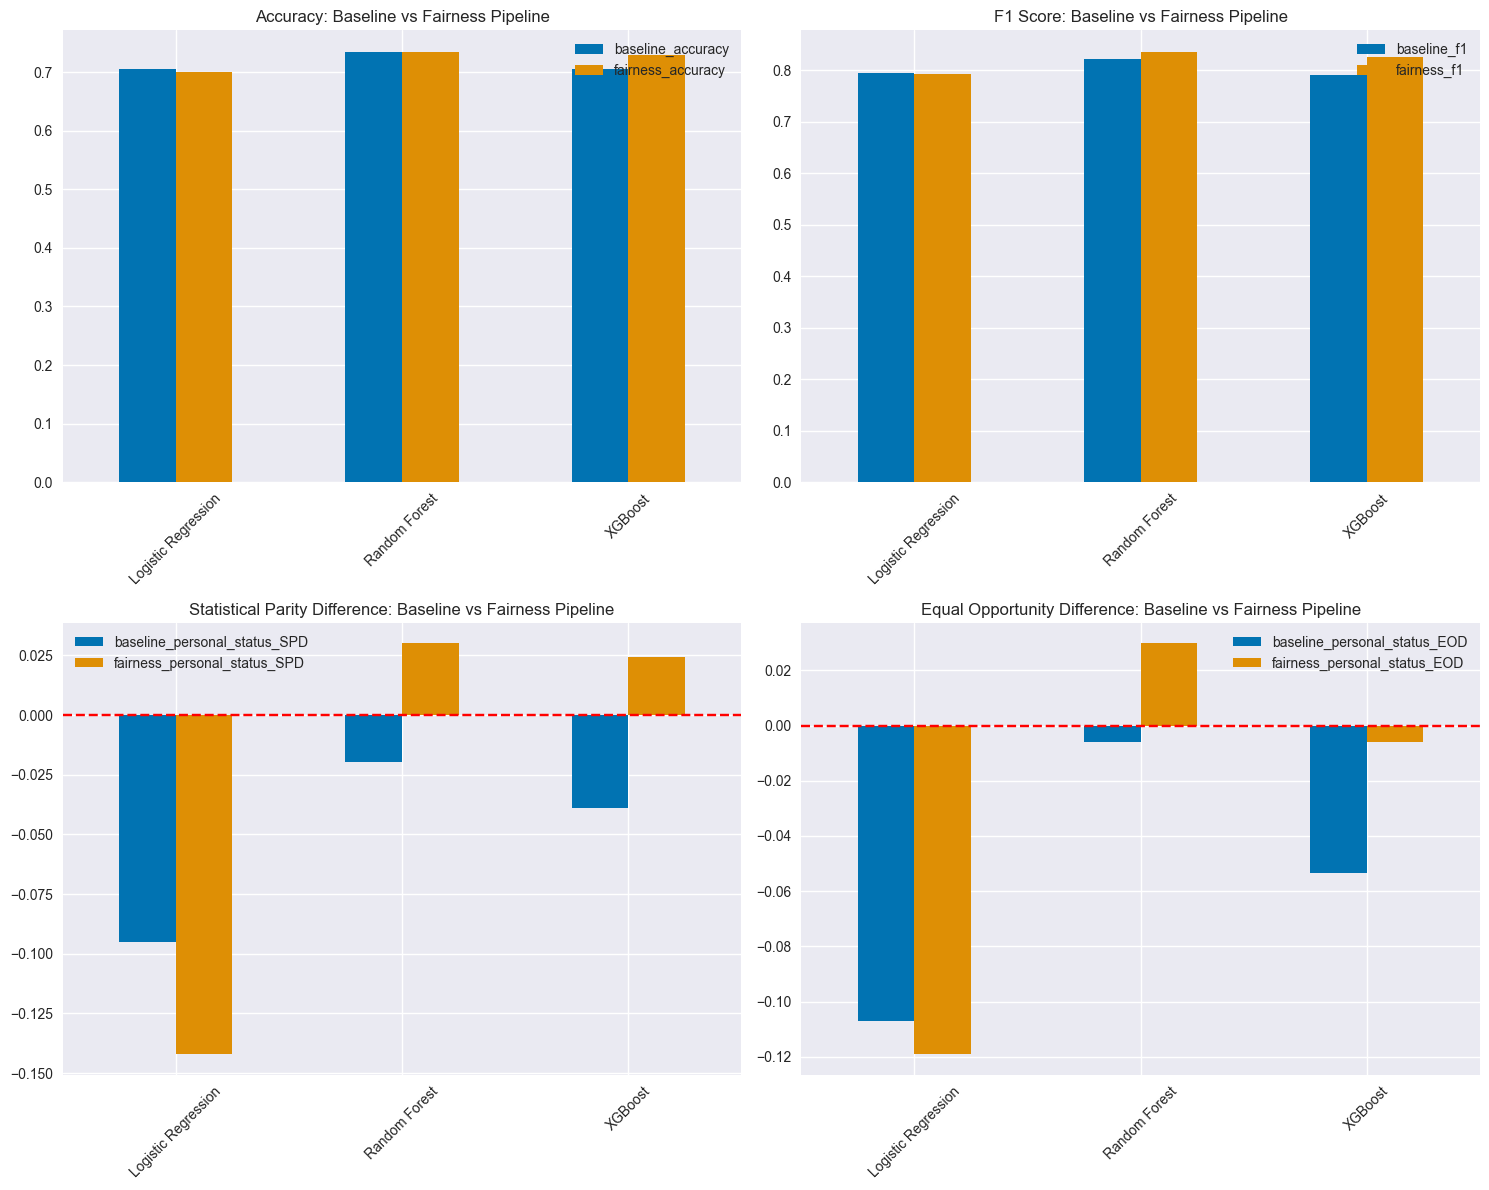

In [109]:
# Cell 11: Compare Baseline vs Fairness Pipeline
# ==========================
# Combine results
comparison_results = pd.concat([
    baseline_results_df.add_prefix('baseline_'), 
    fairness_results_df.add_prefix('fairness_')
], axis=1)

# Calculate improvements
for metric in ['accuracy', 'f1', 'personal_status_SPD', 'personal_status_EOD']:
    if f'baseline_{metric}' in comparison_results.columns and f'fairness_{metric}' in comparison_results.columns:
        comparison_results[f'{metric}_improvement'] = (
            comparison_results[f'fairness_{metric}'] - comparison_results[f'baseline_{metric}']
        )

comparison_results.to_csv('../results/metrics/comparison_results.csv')

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
comparison_results[['baseline_accuracy', 'fairness_accuracy']].plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Accuracy: Baseline vs Fairness Pipeline')
axes[0, 0].tick_params(axis='x', rotation=45)

# F1 comparison
comparison_results[['baseline_f1', 'fairness_f1']].plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('F1 Score: Baseline vs Fairness Pipeline')
axes[0, 1].tick_params(axis='x', rotation=45)

# SPD comparison
if 'baseline_personal_status_SPD' in comparison_results.columns:
    comparison_results[['baseline_personal_status_SPD', 'fairness_personal_status_SPD']].plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Statistical Parity Difference: Baseline vs Fairness Pipeline')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].axhline(y=0, color='r', linestyle='--')

# EOD comparison
if 'baseline_personal_status_EOD' in comparison_results.columns:
    comparison_results[['baseline_personal_status_EOD', 'fairness_personal_status_EOD']].plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Equal Opportunity Difference: Baseline vs Fairness Pipeline')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.savefig('../results/figures/baseline_vs_fairness_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Create interpretation file
interpretation_text = """
BASELINE VS FAIRNESS PIPELINE COMPARISON
This comparison shows the performance of models before and after applying the complete fairness pipeline.

Key insights:
- Accuracy and F1 score show model performance
- Statistical Parity Difference (SPD) measures demographic parity (closer to 0 is better)
- Equal Opportunity Difference (EOD) measures equality of true positive rates (closer to 0 is better)

Positive improvement values indicate the fairness pipeline improved that metric.
"""

save_interpretation(
    'baseline_vs_fairness_comparison.txt',
    'Baseline vs Fairness Pipeline Comparison',
    interpretation_text,
    {
        'Best accuracy improvement': f"{comparison_results['accuracy_improvement'].max():.4f}",
        'Best SPD improvement': f"{comparison_results['personal_status_SPD_improvement'].max():.4f}",
        'Best EOD improvement': f"{comparison_results['personal_status_EOD_improvement'].max():.4f}"
    }
)

Best model based on composite score: XGBoost
Best model uses numpy arrays: False


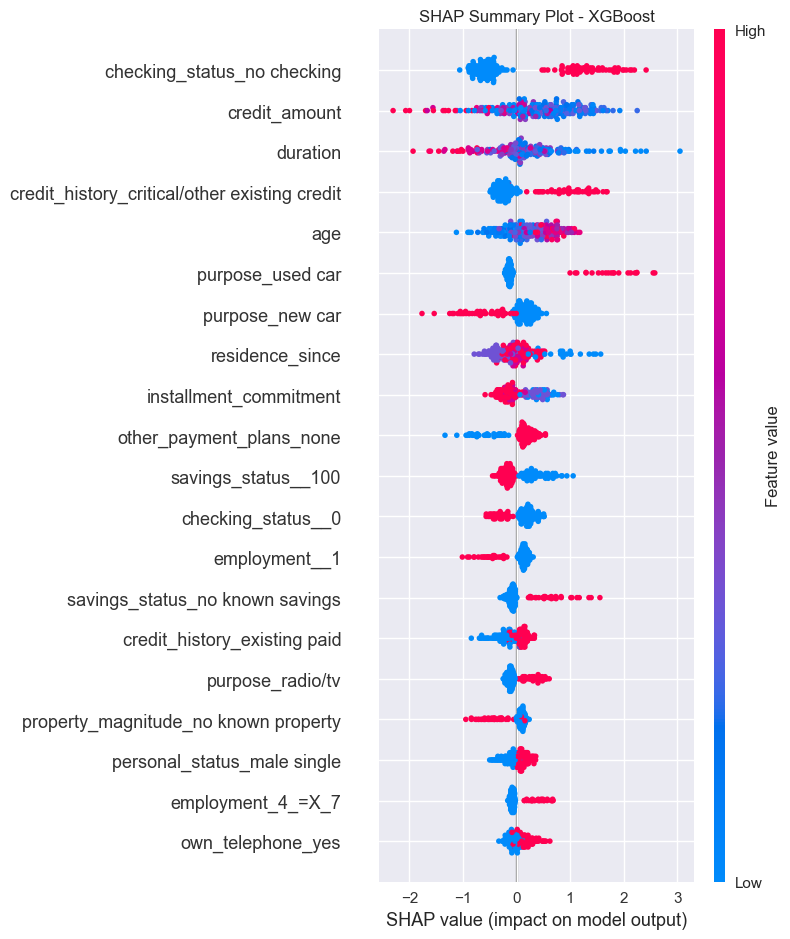

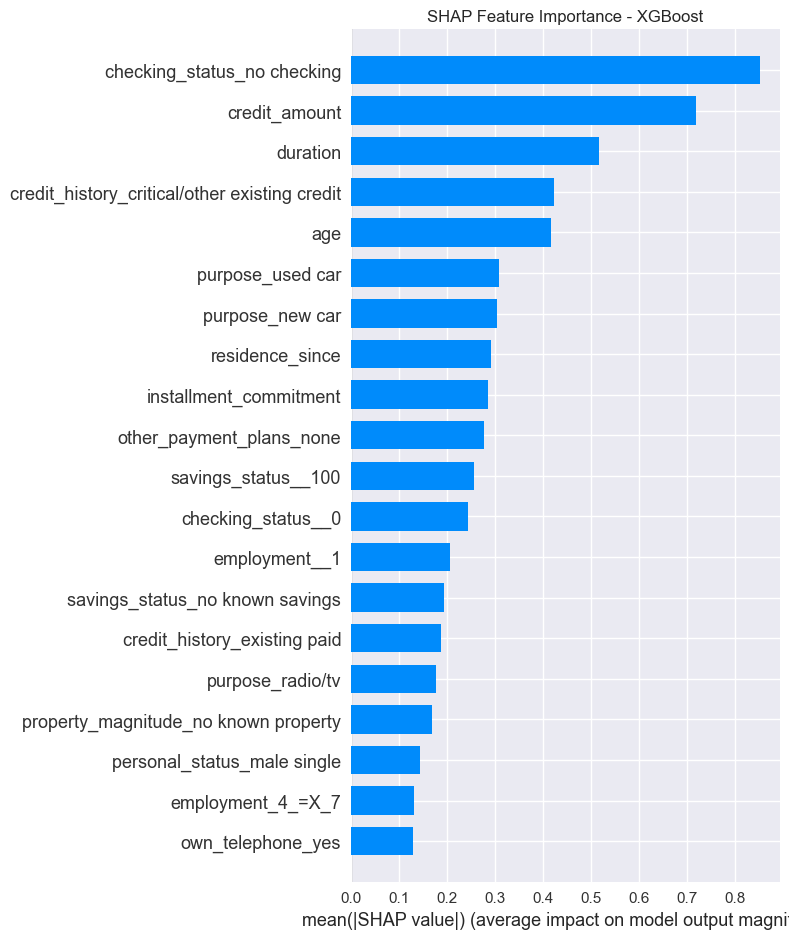

Force plots and decision plots are not available for XGBoost with numpy arrays in this implementation


In [ ]:
# Cell 12: Identify Best Model and SHAP Analysis
# ==========================
# Find the best model based on balanced performance and fairness
# Use a composite score that considers both accuracy and fairness
fairness_metrics = ['personal_status_SPD', 'personal_status_EOD']
performance_metrics = ['accuracy', 'f1']

# Normalize metrics (all should be optimized toward 0 for fairness, higher for performance)
normalized_results = fairness_results_df.copy()
for metric in fairness_metrics:
    if metric in normalized_results.columns:
        # For fairness metrics, we want absolute values closer to 0
        normalized_results[metric] = 1 - np.abs(normalized_results[metric])
        
for metric in performance_metrics:
    if metric in normalized_results.columns:
        # For performance metrics, we want higher values
        normalized_results[metric] = normalized_results[metric]

# Calculate composite score (equal weight to performance and fairness)
composite_scores = {}
for model in normalized_results.index:
    score = 0
    count = 0
    
    for metric in performance_metrics:
        if metric in normalized_results.columns:
            score += normalized_results.loc[model, metric]
            count += 1
            
    for metric in fairness_metrics:
        if metric in normalized_results.columns:
            score += normalized_results.loc[model, metric]
            count += 1
            
    composite_scores[model] = score / count if count > 0 else 0

# Find best model
best_model_name = max(composite_scores, key=composite_scores.get)
print(f"Best model based on composite score: {best_model_name}")

# Load the best model pipeline
best_model_pipeline = joblib.load(f'../models/{best_model_name.replace(" ", "_").lower()}_fairness_pipeline.pkl')
best_model = best_model_pipeline['model']
uses_numpy_arrays = best_model_pipeline.get('uses_numpy_arrays', False)

print(f"Best model type: {'Fairness Pipeline XGBoost' if best_model_name == 'XGBoost' else best_model_name}")
print(f"Best model uses numpy arrays: {uses_numpy_arrays}")

# SHAP analysis - handle different model types appropriately
try:
    if best_model_name == 'XGBoost':
        # This is the Fairness Pipeline XGBoost (not the baseline)
        print("Analyzing Fairness Pipeline XGBoost model...")
        
        # For XGBoost, we need to use the cleaned feature names
        feature_names_clean = joblib.load('../models/feature_names_clean.pkl')
        
        # Create TreeExplainer for XGBoost
        explainer = shap.TreeExplainer(best_model)
        
        # Prepare test data for SHAP
        if uses_numpy_arrays:
            # If model was trained on numpy arrays, use numpy arrays for SHAP
            X_test_shap = X_test_clean.values
            print("Using numpy arrays for SHAP analysis")
        else:
            # If model was trained on DataFrame, use DataFrame for SHAP
            X_test_shap = X_test_clean
            print("Using DataFrame for SHAP analysis")
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X_test_shap)
        
        # For binary classification, we might get a list of arrays
        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap_values = shap_values[1]  # Use the positive class values
        
        # Create summary plot with cleaned feature names
        plt.figure(figsize=(12, 8))
        if uses_numpy_arrays:
            shap.summary_plot(shap_values, X_test_shap, feature_names=feature_names_clean, show=False)
        else:
            shap.summary_plot(shap_values, X_test_clean, feature_names=feature_names_clean, show=False)
        plt.title(f'SHAP Summary Plot - Fairness Pipeline {best_model_name}')
        plt.tight_layout()
        plt.savefig('../results/figures/shap_summary.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create feature importance plot
        plt.figure(figsize=(12, 8))
        if uses_numpy_arrays:
            shap.summary_plot(shap_values, X_test_shap, feature_names=feature_names_clean, 
                             plot_type="bar", show=False)
        else:
            shap.summary_plot(shap_values, X_test_clean, feature_names=feature_names_clean, 
                             plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance - Fairness Pipeline {best_model_name}')
        plt.tight_layout()
        plt.savefig('../results/figures/shap_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Get top features from SHAP
        feature_importance = np.abs(shap_values).mean(0)
        top_features_idx = np.argsort(feature_importance)[-10:]  # Top 10 features
        top_features = [feature_names_clean[i] for i in top_features_idx]
        top_importance = feature_importance[top_features_idx]
        
        # Force plots and decision plots are challenging with TreeExplainer and numpy arrays
        print("Note: Force plots and decision plots are limited with TreeExplainer for XGBoost models")
        
    else:
        # For other models (Logistic Regression, Random Forest)
        print(f"Analyzing {best_model_name} model...")
        
        feature_names_clean = joblib.load('../models/feature_names_clean.pkl')
        explainer = shap.Explainer(best_model, X_train_clean)
        shap_values = explainer(X_test_clean)
        
        # Create summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test_clean, feature_names=feature_names_clean, show=False)
        plt.title(f'SHAP Summary Plot - {best_model_name}')
        plt.tight_layout()
        plt.savefig('../results/figures/shap_summary.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create feature importance plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test_clean, feature_names=feature_names_clean, 
                         plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance - {best_model_name}')
        plt.tight_layout()
        plt.savefig('../results/figures/shap_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Get top features from SHAP
        feature_importance = np.abs(shap_values.values).mean(0)
        top_features_idx = np.argsort(feature_importance)[-10:]  # Top 10 features
        top_features = [feature_names_clean[i] for i in top_features_idx]
        top_importance = feature_importance[top_features_idx]
        
        # Force plot for a representative instance
        plt.figure(figsize=(12, 6))
        shap.force_plot(explainer.expected_value, shap_values[0].values, X_test_clean.iloc[0], 
                        feature_names=feature_names_clean, matplotlib=True, show=False)
        plt.title(f'SHAP Force Plot - First Instance - {best_model_name}')
        plt.tight_layout()
        plt.savefig('../results/figures/shap_force_plot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Decision plot for multiple instances
        plt.figure(figsize=(12, 8))
        shap.decision_plot(explainer.expected_value, shap_values[:10], X_test_clean.iloc[:10], 
                           feature_names=feature_names_clean, show=False)
        plt.title(f'SHAP Decision Plot - First 10 Instances - {best_model_name}')
        plt.tight_layout()
        plt.savefig('../results/figures/shap_decision_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Create interpretation files
    shap_summary_text = f"""
    SHAP SUMMARY PLOT - {best_model_name}
    This plot shows the distribution of SHAP values for each feature. Each point represents a single prediction from the dataset.

    Key insights:
    - Features are ordered by importance (top to bottom)
    - Color represents feature value (red = high, blue = low)
    - Position on x-axis shows impact on prediction (right = higher probability of positive class)
    - Wider distributions indicate more important features
    """

    shap_importance_text = f"""
    SHAP FEATURE IMPORTANCE - {best_model_name}
    This plot shows the mean absolute SHAP value for each feature, which represents overall feature importance.

    Key insights:
    - Features are ordered by importance (top to bottom)
    - Bar length represents mean absolute impact on model output
    - The most important features have the largest impact on predictions
    """

    save_interpretation(
        'shap_summary.txt',
        'SHAP Summary Plot Interpretation',
        shap_summary_text,
        {'Top 5 features by importance': ', '.join(top_features[-5:])}
    )

    save_interpretation(
        'shap_feature_importance.txt',
        'SHAP Feature Importance Interpretation',
        shap_importance_text,
        {f'Feature {i+1}': f'{feature} (importance: {importance:.4f})' 
         for i, (feature, importance) in enumerate(zip(reversed(top_features[-10:]), reversed(top_importance[-10:])))}
    )

    # For non-XGBoost models, add additional interpretation files
    if best_model_name != 'XGBoost':
        force_plot_text = f"""
        SHAP FORCE PLOT - {best_model_name}
        This plot shows the contribution of each feature to the prediction for a single instance.

        Key insights:
        - Base value is the average model prediction
        - Arrows show how each feature pushes the prediction from the base value
        - Red arrows increase the prediction, blue arrows decrease it
        - The final prediction is the sum of all feature contributions plus the base value
        """

        decision_plot_text = f"""
        SHAP DECISION PLOT - {best_model_name}
        This plot shows how features contribute to the prediction for multiple instances.

        Key insights:
        - Each line represents one instance's prediction path
        - The x-axis shows the model output value
        - Features are listed in order of importance
        - The plot shows how each feature contributes to moving from the base value to the final prediction
        """

        save_interpretation(
            'shap_force_plot.txt',
            'SHAP Force Plot Interpretation',
            force_plot_text,
            {'Base value': f'{explainer.expected_value:.4f}',
             'Final prediction': f'{explainer.expected_value + shap_values[0].values.sum():.4f}'}
        )

        save_interpretation(
            'shap_decision_plot.txt',
            'SHAP Decision Plot Interpretation',
            decision_plot_text,
            {'Number of instances shown': '10',
             'Base value': f'{explainer.expected_value:.4f}'}
        )

except Exception as e:
    print(f"Error during SHAP analysis: {e}")
    import traceback
    traceback.print_exc()
    print("Skipping SHAP analysis for this model")
    
    # Create placeholder interpretation files
    save_interpretation(
        'shap_summary.txt',
        'SHAP Summary Plot Interpretation',
        f"SHAP analysis could not be completed for {best_model_name}. Error: {e}",
        {}
    )
    
    save_interpretation(
        'shap_feature_importance.txt',
        'SHAP Feature Importance Interpretation',
        f"SHAP analysis could not be completed for {best_model_name}. Error: {e}",
        {}
    )